# 4. Évolution du Discours de Haine et des Biais (1960-2020)

## 📚 Cadre Théorique : Sémantique et Pragmatique (Maria Boritchev)

Ce notebook s'appuie sur le cours **5-HSS_0EL44_TP_Semantics** :

### 🎯 Niveaux d'Analyse Linguistique

1. **Niveau Sémantique** : Étude du sens **littéral** des mots
   - Construction de lexiques d'insultes et de stéréotypes
   - Identification des termes problématiques dans leur forme brute

2. **Niveau Pragmatique** : Étude du sens **en contexte**
   - Une insulte peut être utilisée pour **dénoncer** un comportement
   - Ou pour le **renforcer** (différenciation critique vs renforcement)
   - Analyse des **N-grams** : mots entourant les termes cibles

3. **Niveau Socio-technique** : Le cinéma comme système structurant
   - Le cinéma n'est pas qu'un **miroir** de la société
   - Il **structure** aussi la pensée du public

### 📊 Questions de Recherche

1. **Peak Prejudices** : À quelle décennie les scripts étaient-ils les plus violents verbalement ?
2. **Linguistic Shift** : Certaines insultes disparaissent-elles au profit de micro-agressions ?
3. **Co-occurrence Patterns** : Quels rôles sociaux sont attribués aux minorités ?
4. **Semantic Drift** : Les qualificatifs des minorités évoluent-ils vers le pôle "Power/Agency" ?

---

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
from collections import Counter, defaultdict
import nltk
from nltk import ngrams, word_tokenize
from nltk.corpus import stopwords

# Word Embeddings
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Nos modules
from dictionaries import (
    GENDER_WORDS, GENDER_STEREOTYPES, GENDERED_ROLES,
    ETHNICITY_WORDS, RACIAL_STEREOTYPES,
    LGBTQ_WORDS, HOMOPHOBIC_CONTEXT,
    ACTION_VERBS, ADJECTIVES
)

# Configuration
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

# NLTK resources
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)

stop_words = set(stopwords.words('english'))

print("✅ Imports réussis")

✅ Imports réussis


/Users/antoineollivier/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Chargement des Données

In [2]:
# Charger les données nettoyées
data_path = Path('../data/processed/scripts_clean.pkl')

if not data_path.exists():
    raise FileNotFoundError(
        "Fichier scripts_clean.pkl introuvable. "
        "Veuillez d'abord exécuter le notebook 0_clean_data.ipynb"
    )

df = pd.read_pickle(data_path)
print(f"✅ {len(df)} scripts chargés")
print(f"   Période : {df['release_year'].min():.0f} - {df['release_year'].max():.0f}")
print(f"   Décennies : {sorted(df['decade'].unique())}")

✅ 1787 scripts chargés
   Période : 1960 - 2020
   Décennies : [np.int64(1960), np.int64(1970), np.int64(1980), np.int64(1990), np.int64(2000), np.int64(2010), np.int64(2020)]


## 2. Construction des Lexiques Scientifiques

### 📖 Niveau Sémantique : Définition des Termes Cibles

Basés sur la recherche en sciences sociales et linguistique computationnelle.

In [3]:
# Lexiques de Biais - Niveau Sémantique (sens littéral)

# SEXISME : Objectification + Domesticité + Insultes
SEXISM_LEXICON = {
    'objectification': GENDER_STEREOTYPES['female_objectification'],
    'negative_stereotypes': GENDER_STEREOTYPES['female_negative'],
    'domestic_roles': GENDERED_ROLES['female_domestic'] if 'female_domestic' in GENDERED_ROLES else 
                      ['housewife', 'mother', 'nurse', 'secretary', 'maid', 'cook', 'babysitter']
}

# Aplatir en une seule liste
SEXISM_ALL = []
for category in SEXISM_LEXICON.values():
    SEXISM_ALL.extend(category)


# RACISME : Ségrégation + Slurs + Stéréotypes coloniaux
RACISM_LEXICON = {
    'criminal': RACIAL_STEREOTYPES['criminal'],
    'poverty': RACIAL_STEREOTYPES['poverty'],
    'exotic': RACIAL_STEREOTYPES['exotic'],
    'segregation': ['savage', 'primitive', 'inferior', 'slave', 'servant', 'subordinate']
}

RACISM_ALL = []
for category in RACISM_LEXICON.values():
    RACISM_ALL.extend(category)


# HOMOPHOBIE : Marginalisation + Slurs
HOMOPHOBIA_LEXICON = {
    'slurs': LGBTQ_WORDS['slurs'] if 'slurs' in LGBTQ_WORDS else [],
    'stigma': HOMOPHOBIC_CONTEXT + ['deviant', 'abnormal', 'unnatural', 'pervert', 'sick']
}

HOMOPHOBIA_ALL = []
for category in HOMOPHOBIA_LEXICON.values():
    HOMOPHOBIA_ALL.extend(category)


print("📚 Lexiques construits :")
print(f"   Sexisme : {len(SEXISM_ALL)} termes")
print(f"   Racisme : {len(RACISM_ALL)} termes")
print(f"   Homophobie : {len(HOMOPHOBIA_ALL)} termes")
print(f"\n   TOTAL : {len(SEXISM_ALL) + len(RACISM_ALL) + len(HOMOPHOBIA_ALL)} termes de biais")

📚 Lexiques construits :
   Sexisme : 34 termes
   Racisme : 26 termes
   Homophobie : 21 termes

   TOTAL : 81 termes de biais


## 3. Mesure de la Densité de Biais (Fréquence Normalisée)

### 📐 Méthodologie

**Densité de biais** = (Nombre de termes problématiques / Nombre total de mots) × 1000

Permet de comparer des films de durées différentes (court-métrage vs film de 3h).

In [4]:
def preprocess_tokens(text):
    """
    Tokenisation et nettoyage (Niveau Morphologique - Boritchev).
    """
    if not isinstance(text, str):
        return []
    
    # Tokenisation
    tokens = word_tokenize(text.lower())
    
    # Filtrer : garder uniquement les mots alphabétiques
    tokens = [t for t in tokens if t.isalpha()]
    
    return tokens


def calculate_bias_density(text, lexicon):
    """
    Calcule la densité de biais (fréquence normalisée).
    
    Returns:
        Densité (termes pour 1000 mots)
    """
    tokens = preprocess_tokens(text)
    
    if len(tokens) == 0:
        return 0.0
    
    # Compter les matches
    matches = [t for t in tokens if t in lexicon]
    
    # Densité pour 1000 mots
    density = (len(matches) / len(tokens)) * 1000
    
    return density


# Calculer la densité pour chaque film
print("🔍 Calcul des densités de biais...\n")

df['sexism_density'] = df['clean_text'].apply(lambda x: calculate_bias_density(x, SEXISM_ALL))
df['racism_density'] = df['clean_text'].apply(lambda x: calculate_bias_density(x, RACISM_ALL))
df['homophobia_density'] = df['clean_text'].apply(lambda x: calculate_bias_density(x, HOMOPHOBIA_ALL))
df['total_bias_density'] = df['sexism_density'] + df['racism_density'] + df['homophobia_density']

print("✅ Densités calculées")
print(f"\n📊 Statistiques globales (pour 1000 mots) :")
print(f"   Densité sexisme : {df['sexism_density'].mean():.2f} ± {df['sexism_density'].std():.2f}")
print(f"   Densité racisme : {df['racism_density'].mean():.2f} ± {df['racism_density'].std():.2f}")
print(f"   Densité homophobie : {df['homophobia_density'].mean():.2f} ± {df['homophobia_density'].std():.2f}")
print(f"   Densité totale : {df['total_bias_density'].mean():.2f} ± {df['total_bias_density'].std():.2f}")

🔍 Calcul des densités de biais...

✅ Densités calculées

📊 Statistiques globales (pour 1000 mots) :
   Densité sexisme : 1.59 ± 1.32
   Densité racisme : 0.30 ± 0.35
   Densité homophobie : 0.33 ± 0.22
   Densité totale : 2.22 ± 1.40


## 4. Peak Prejudices : Identification de la Décennie la Plus Violente

### 🎯 Question CSS : À quelle période le cinéma était-il le plus discriminant ?


In [5]:
# Agréger par décennie
df_evolution = df.groupby('decade').agg({
    'sexism_density': ['mean', 'std', 'median'],
    'racism_density': ['mean', 'std', 'median'],
    'homophobia_density': ['mean', 'std', 'median'],
    'total_bias_density': ['mean', 'std', 'median'],
    'title': 'count'
}).reset_index()

# Aplatir les colonnes multi-niveaux
df_evolution.columns = ['_'.join(col).strip('_') if col[1] else col[0] 
                        for col in df_evolution.columns.values]
df_evolution.rename(columns={'title_count': 'num_films'}, inplace=True)

print("📊 Évolution par décennie :")
display(df_evolution)

# Identifier le Peak Prejudices
peak_decade = df_evolution.loc[df_evolution['total_bias_density_mean'].idxmax()]

print(f"\n🚨 PEAK PREJUDICES : {int(peak_decade['decade'])}s")
print(f"   Densité moyenne : {peak_decade['total_bias_density_mean']:.2f} termes/1000 mots")
print(f"   Films analysés : {int(peak_decade['num_films'])}")

📊 Évolution par décennie :


,decade,sexism_density_mean,sexism_density_std,sexism_density_median,racism_density_mean,racism_density_std,racism_density_median,homophobia_density_mean,homophobia_density_std,homophobia_density_median,total_bias_density_mean,total_bias_density_std,total_bias_density_median,num_films
0,1960,1.560811,1.175430,1.206304,0.338014,0.388522,0.256032,0.293481,0.170056,0.267425,2.192306,1.262175,1.862691,34
1,1970,1.459559,0.925405,1.239040,0.349589,0.385333,0.227616,0.322776,0.229395,0.278381,2.131924,1.025793,1.908778,80
2,1980,1.729914,1.933893,1.360458,0.338625,0.442347,0.227411,0.332785,0.219427,0.296535,2.401325,2.004318,2.010328,187
3,1990,1.533790,1.264359,1.264906,0.308707,0.311147,0.230991,0.353940,0.264700,0.309948,2.196437,1.377094,1.887081,378
4,2000,1.482049,0.964054,1.248707,0.288262,0.331925,0.198776,0.315788,0.193547,0.267612,2.086098,1.060428,1.873480,521
5,2010,1.660767,1.210193,1.355462,0.296965,0.352738,0.207907,0.330770,0.198172,0.299985,2.288502,1.252567,2.040900,575
6,2020,3.033919,5.661917,1.209621,0.296878,0.241115,0.202077,0.281601,0.215475,0.228910,3.612399,5.886482,1.618575,12



🚨 PEAK PREJUDICES : 2020s
   Densité moyenne : 3.61 termes/1000 mots
   Films analysés : 12


## 5. Visualisation : Stacked Area Chart (Aires Empilées)

### 📈 Part Relative des Biais dans le "Budget d'Insultes"

Montre si la sensibilité sociale évolue à des rythmes différents.

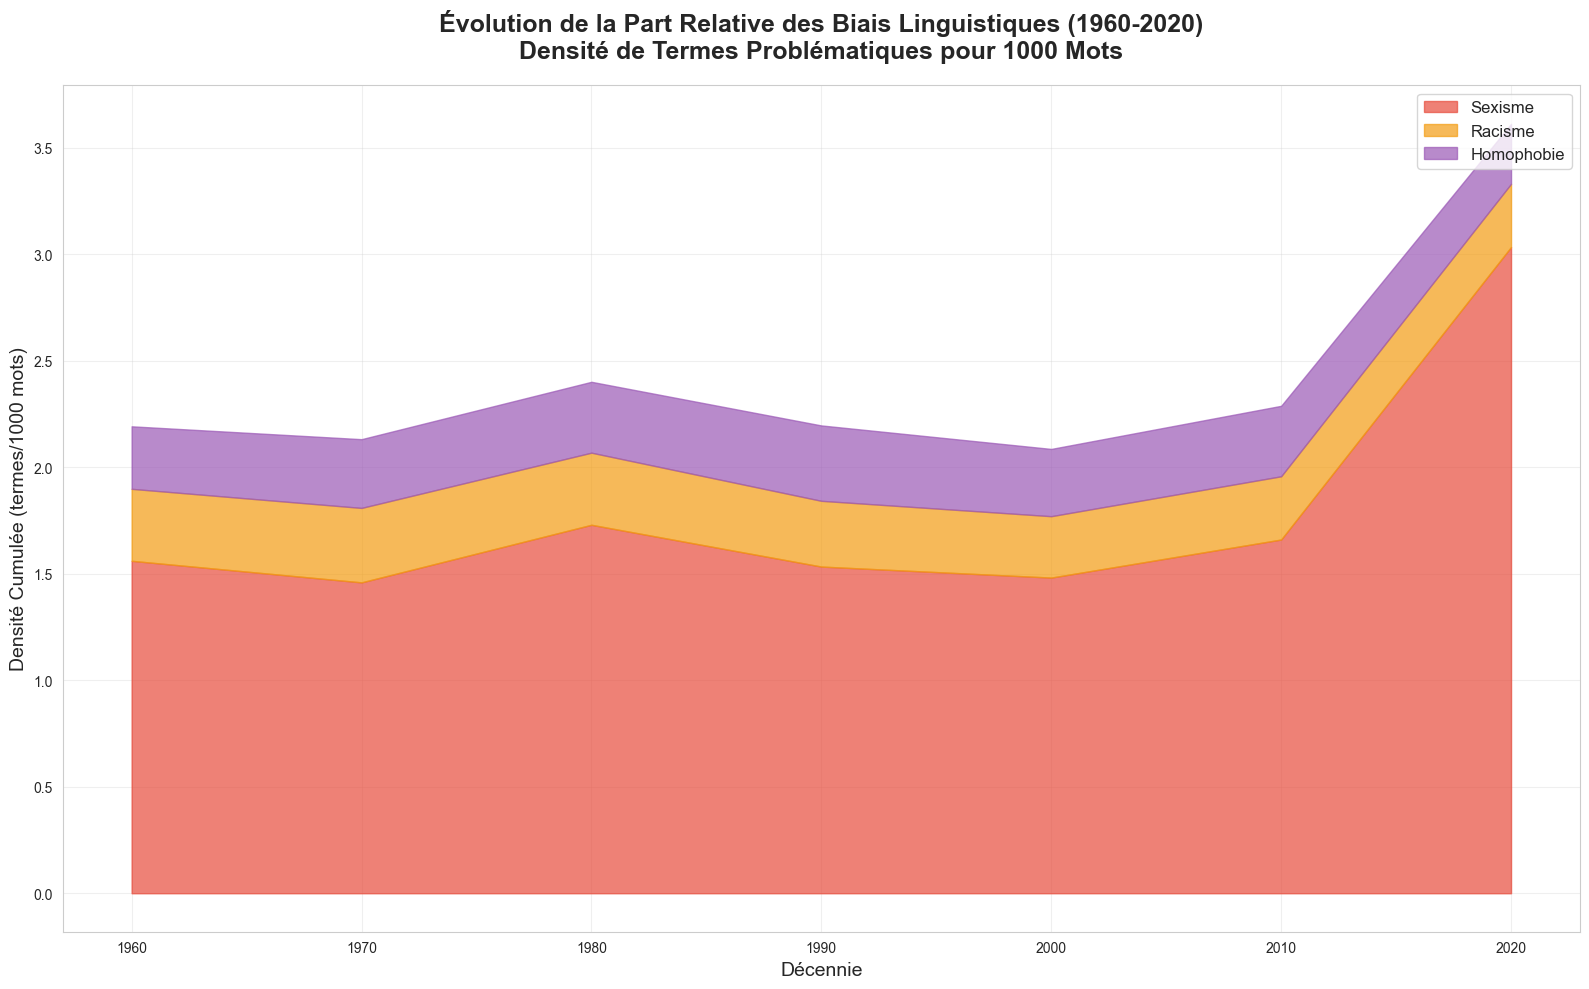

✅ Graphique sauvegardé : results/figures/stacked_area_bias_evolution.png

📊 Analyse de Tendance :
   Sexisme : +94.4% entre 1960s et 2020s
   Racisme : -12.2%
   Homophobie : -4.0%


In [6]:
# Préparer les données pour le stacked area chart
decades = df_evolution['decade']
sexism = df_evolution['sexism_density_mean']
racism = df_evolution['racism_density_mean']
homophobia = df_evolution['homophobia_density_mean']

# Créer le graphique
fig, ax = plt.subplots(figsize=(16, 10))

ax.fill_between(decades, 0, sexism, 
                label='Sexisme', alpha=0.7, color='#e74c3c')
ax.fill_between(decades, sexism, sexism + racism, 
                label='Racisme', alpha=0.7, color='#f39c12')
ax.fill_between(decades, sexism + racism, sexism + racism + homophobia, 
                label='Homophobie', alpha=0.7, color='#9b59b6')

ax.set_title('Évolution de la Part Relative des Biais Linguistiques (1960-2020)\n' +
             'Densité de Termes Problématiques pour 1000 Mots',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Décennie', fontsize=14)
ax.set_ylabel('Densité Cumulée (termes/1000 mots)', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/stacked_area_bias_evolution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé : results/figures/stacked_area_bias_evolution.png")

# Analyse de tendance
print("\n📊 Analyse de Tendance :")

# Calculer la variation relative entre première et dernière décennie
first_decade = df_evolution.iloc[0]
last_decade = df_evolution.iloc[-1]

sexism_change = ((last_decade['sexism_density_mean'] - first_decade['sexism_density_mean']) / 
                 first_decade['sexism_density_mean']) * 100
racism_change = ((last_decade['racism_density_mean'] - first_decade['racism_density_mean']) / 
                 first_decade['racism_density_mean']) * 100
homophobia_change = ((last_decade['homophobia_density_mean'] - first_decade['homophobia_density_mean']) / 
                     first_decade['homophobia_density_mean']) * 100

print(f"   Sexisme : {sexism_change:+.1f}% entre {int(first_decade['decade'])}s et {int(last_decade['decade'])}s")
print(f"   Racisme : {racism_change:+.1f}%")
print(f"   Homophobie : {homophobia_change:+.1f}%")

## 6. Analyse Pragmatique : N-grams et Contexte

### 🔍 Niveau Pragmatique (Boritchev)

Analyser les **mots entourant** les termes cibles pour identifier les comportements associés.

**Exemple** : "femme" est-il associé à des verbes de soumission ou de pouvoir ?

In [7]:
def extract_ngrams_around_target(text, target_words, window=5, n=2):
    """
    Extrait les N-grams autour des mots cibles.
    
    Args:
        text: Texte du script
        target_words: Liste de mots cibles (ex: ['woman', 'women'])
        window: Taille de la fenêtre de contexte
        n: Taille des N-grams (2=bigrams, 3=trigrams)
    
    Returns:
        Liste de N-grams (tuples)
    """
    tokens = preprocess_tokens(text)
    
    if len(tokens) < n:
        return []
    
    contexts = []
    
    # Trouver les positions des mots cibles
    for i, token in enumerate(tokens):
        if token in target_words:
            # Extraire la fenêtre de contexte
            start = max(0, i - window)
            end = min(len(tokens), i + window + 1)
            context_tokens = tokens[start:end]
            
            # Générer les N-grams
            context_ngrams = list(ngrams(context_tokens, n))
            contexts.extend(context_ngrams)
    
    return contexts


def analyze_associations_by_decade(df, target_words, label, window=5):
    """
    Analyse les associations (bigrams) pour un groupe social par décennie.
    """
    results = {}
    
    for decade in sorted(df['decade'].unique()):
        decade_df = df[df['decade'] == decade]
        
        all_bigrams = []
        for text in decade_df['clean_text']:
            bigrams = extract_ngrams_around_target(text, target_words, window=window, n=2)
            all_bigrams.extend(bigrams)
        
        # Compter les bigrams les plus fréquents
        bigram_counts = Counter(all_bigrams)
        
        results[decade] = bigram_counts.most_common(10)
    
    return results


print("🔍 Analyse des N-grams par groupe social...\n")

# Analyser les femmes
female_targets = GENDER_WORDS['female']
female_associations = analyze_associations_by_decade(df, female_targets, 'Femmes', window=5)

# Analyser les minorités ethniques
minority_targets = (ETHNICITY_WORDS.get('african_american', []) + 
                   ETHNICITY_WORDS.get('hispanic', []) + 
                   ETHNICITY_WORDS.get('asian', []))
minority_associations = analyze_associations_by_decade(df, minority_targets, 'Minorités', window=5)

print("✅ Analyse des associations terminée")

# Afficher quelques exemples
print("\n📝 Exemples de Bigrams - FEMMES (1960s vs 2010s) :\n")

if 1960 in female_associations:
    print("   1960s - TOP 10 :")
    for bigram, count in female_associations[1960][:10]:
        print(f"      {' '.join(bigram):30s} : {count:3d} occurrences")

print()

if 2010 in female_associations:
    print("   2010s - TOP 10 :")
    for bigram, count in female_associations[2010][:10]:
        print(f"      {' '.join(bigram):30s} : {count:3d} occurrences")

🔍 Analyse des N-grams par groupe social...

✅ Analyse des associations terminée

📝 Exemples de Bigrams - FEMMES (1960s vs 2010s) :

   1960s - TOP 10 :
      text she                       : 1405 occurrences
      she is                         : 464 occurrences
      dialog she                     : 441 occurrences
      as she                         : 431 occurrences
      text her                       : 427 occurrences
      her text                       : 423 occurrences
      dialog dialog                  : 410 occurrences
      to her                         : 390 occurrences
      at her                         : 362 occurrences
      text he                        : 335 occurrences

   2010s - TOP 10 :
      text she                       : 26078 occurrences
      her text                       : 8919 occurrences
      dialog dialog                  : 8176 occurrences
      dialog she                     : 7996 occurrences
      to her                         : 7391 occurre

## 7. Heatmap de Co-occurrence : Groupes Sociaux × Comportements

### 🔥 Visualisation des Rôles Attribués

**Importance** : Le racisme/sexisme n'est pas que dans l'insulte, mais dans le **rôle social** attribué par le script.

🔍 Calcul de la matrice de co-occurrence...
   (Cela peut prendre quelques minutes)



/var/folders/nx/9n0zm1816l1gbyy2500y8d580000gn/T/ipykernel_58230/3599579471.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.8916206881365953' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.loc[group_label] = (matrix.loc[group_label] / total_mentions) * 100
/var/folders/nx/9n0zm1816l1gbyy2500y8d580000gn/T/ipykernel_58230/3599579471.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5257909670275746' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  matrix.loc[group_label] = (matrix.loc[group_label] / total_mentions) * 100
/var/folders/nx/9n0zm1816l1gbyy2500y8d580000gn/T/ipykernel_58230/3599579471.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Val

✅ Matrice calculée

📊 Matrice de Co-occurrence (% de co-occurrences par mention) :


,Violence,Pouvoir,Soumission,Émotion,Domesticité,Crime,Pauvreté
Femmes,1.89,0.53,0.42,1.29,5.90,0.15,0.16
Hommes,2.85,0.71,0.55,0.92,1.44,0.28,0.16
Afro-Américains,1.85,0.68,0.44,0.61,0.98,0.26,0.20
Asiatiques,2.59,1.20,0.56,0.59,1.29,0.61,0.12
Hispaniques,2.27,0.53,0.43,0.56,1.84,0.49,0.20
LGBTQ+,1.83,0.53,0.23,0.38,1.22,0.23,0.31


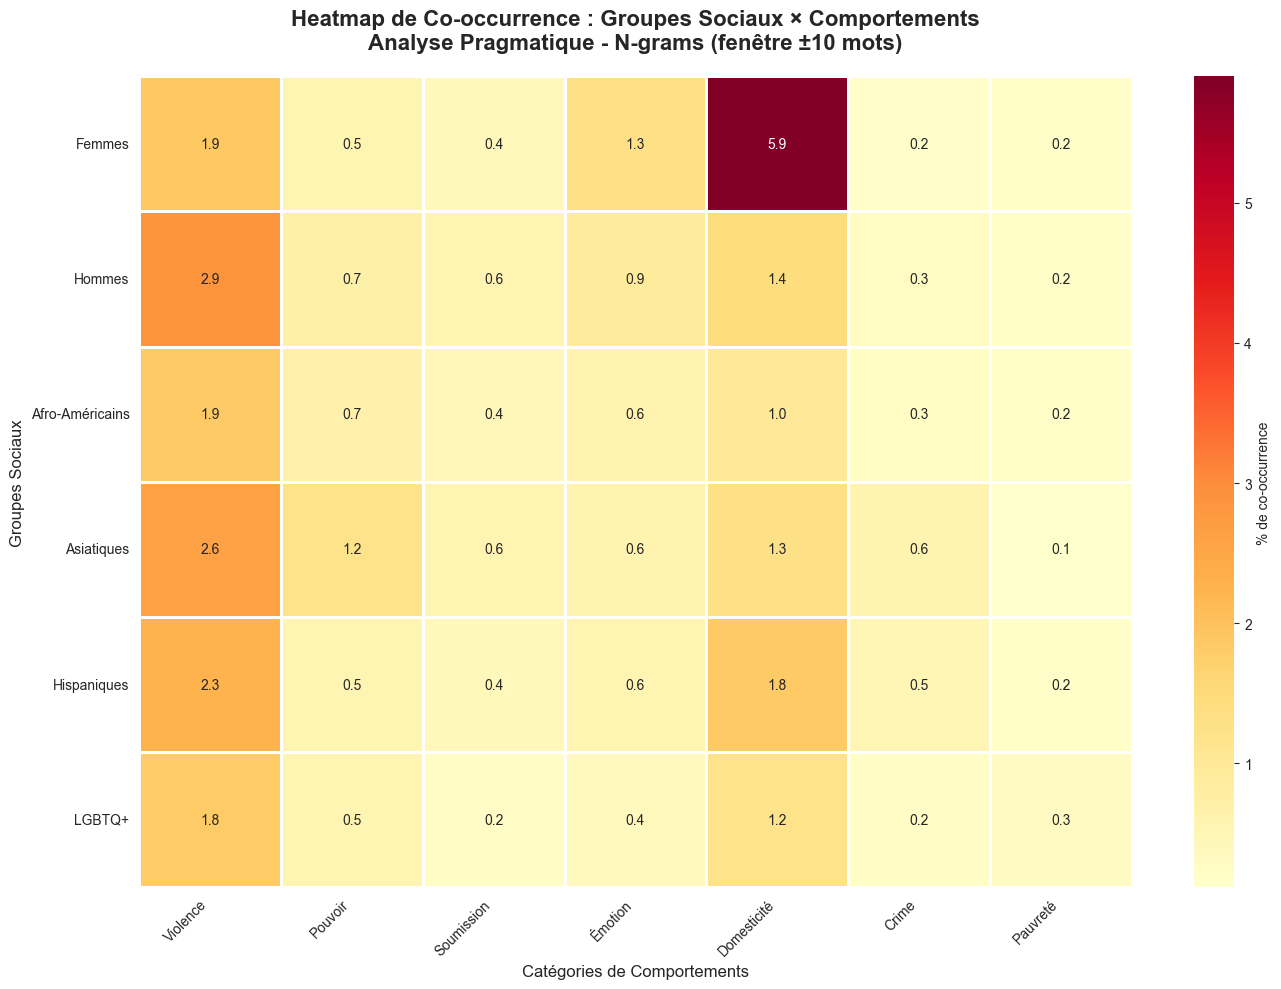


✅ Heatmap sauvegardée : results/figures/cooccurrence_heatmap.png


In [8]:
def calculate_cooccurrence_matrix(df, social_groups, behavior_categories):
    """
    Calcule une matrice de co-occurrence Groupes × Comportements.
    
    Args:
        df: DataFrame avec les scripts
        social_groups: Dict {label: [termes]}
        behavior_categories: Dict {label: [termes]}
    
    Returns:
        DataFrame matrice de co-occurrence (fréquences normalisées)
    """
    matrix = pd.DataFrame(0, 
                         index=list(social_groups.keys()), 
                         columns=list(behavior_categories.keys()))
    
    for text in df['clean_text']:
        tokens = preprocess_tokens(text)
        
        # Pour chaque groupe social
        for group_label, group_words in social_groups.items():
            # Trouver les positions des mots du groupe
            group_positions = [i for i, t in enumerate(tokens) if t in group_words]
            
            # Pour chaque position, chercher des comportements dans une fenêtre
            for pos in group_positions:
                window_start = max(0, pos - 10)
                window_end = min(len(tokens), pos + 10)
                window_tokens = tokens[window_start:window_end]
                
                # Compter les comportements dans la fenêtre
                for behavior_label, behavior_words in behavior_categories.items():
                    matches = sum(1 for t in window_tokens if t in behavior_words)
                    matrix.loc[group_label, behavior_label] += matches
    
    # Normaliser par le nombre total de mentions de chaque groupe
    for group_label, group_words in social_groups.items():
        total_mentions = 0
        for text in df['clean_text']:
            tokens = preprocess_tokens(text)
            total_mentions += sum(1 for t in tokens if t in group_words)
        
        if total_mentions > 0:
            matrix.loc[group_label] = (matrix.loc[group_label] / total_mentions) * 100
    
    return matrix


# Définir les groupes sociaux
SOCIAL_GROUPS = {
    'Femmes': GENDER_WORDS['female'],
    'Hommes': GENDER_WORDS['male'],
    'Afro-Américains': ETHNICITY_WORDS.get('african_american', ['black', 'african']),
    'Asiatiques': ETHNICITY_WORDS.get('asian', ['asian', 'chinese', 'japanese']),
    'Hispaniques': ETHNICITY_WORDS.get('hispanic', ['hispanic', 'latino', 'latina']),
    'LGBTQ+': LGBTQ_WORDS.get('neutral', ['gay', 'lesbian', 'queer', 'transgender'])
}

# Définir les catégories de comportements
BEHAVIOR_CATEGORIES = {
    'Violence': ACTION_VERBS.get('violence', ['kill', 'fight', 'attack', 'shoot', 'beat']),
    'Pouvoir': ACTION_VERBS.get('power', ['lead', 'command', 'control', 'decide', 'rule']),
    'Soumission': ACTION_VERBS.get('submission', ['obey', 'serve', 'submit', 'follow', 'comply']),
    'Émotion': ACTION_VERBS.get('emotion', ['cry', 'scream', 'feel', 'worry', 'fear']),
    'Domesticité': ['cook', 'clean', 'care', 'nurture', 'raise', 'mother'],
    'Crime': RACIAL_STEREOTYPES['criminal'],
    'Pauvreté': RACIAL_STEREOTYPES['poverty']
}

print("🔍 Calcul de la matrice de co-occurrence...")
print("   (Cela peut prendre quelques minutes)\n")

cooccurrence_matrix = calculate_cooccurrence_matrix(df, SOCIAL_GROUPS, BEHAVIOR_CATEGORIES)

print("✅ Matrice calculée\n")
print("📊 Matrice de Co-occurrence (% de co-occurrences par mention) :")
display(cooccurrence_matrix.round(2))

# Visualisation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(cooccurrence_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=1, cbar_kws={'label': '% de co-occurrence'})

plt.title('Heatmap de Co-occurrence : Groupes Sociaux × Comportements\n' +
          'Analyse Pragmatique - N-grams (fenêtre ±10 mots)',
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Catégories de Comportements', fontsize=12)
plt.ylabel('Groupes Sociaux', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('../results/figures/cooccurrence_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Heatmap sauvegardée : results/figures/cooccurrence_heatmap.png")

## 8. Word2Vec Diachronique : Semantic Drift vers Power/Agency

### 🧠 Analyse de Proximité Sémantique

**Question** : Les qualificatifs des minorités se déplacent-ils vers le pôle "Power/Agency" au fil du temps ?

Utilisation de **Word Embeddings** (similaire à node2vec en esprit) pour mesurer l'évolution sémantique.

In [9]:
def train_word2vec_by_decade(df, decade):
    """
    Entraîne un modèle Word2Vec pour une décennie.
    """
    decade_df = df[df['decade'] == decade]
    
    # Tokeniser tous les textes
    sentences = []
    for text in decade_df['clean_text']:
        tokens = preprocess_tokens(text)
        if len(tokens) > 10:  # Minimum de tokens
            sentences.append(tokens)
    
    if len(sentences) < 5:
        return None
    
    # Entraîner Word2Vec
    model = Word2Vec(sentences=sentences, 
                     vector_size=100, 
                     window=5, 
                     min_count=5, 
                     workers=4, 
                     sg=1,  # Skip-gram
                     epochs=10)
    
    return model


def calculate_semantic_proximity(model, target_words, reference_words):
    """
    Calcule la proximité sémantique moyenne entre deux ensembles de mots.
    
    Returns:
        Similarité cosinus moyenne (0-1)
    """
    if model is None:
        return 0.0
    
    similarities = []
    
    for target in target_words:
        if target not in model.wv:
            continue
        
        for ref in reference_words:
            if ref not in model.wv:
                continue
            
            sim = model.wv.similarity(target, ref)
            similarities.append(sim)
    
    if len(similarities) == 0:
        return 0.0
    
    return np.mean(similarities)


print("🧠 Entraînement des modèles Word2Vec par décennie...")
print("   (Cela peut prendre 5-10 minutes)\n")

# Entraîner un modèle par décennie
models_by_decade = {}

for decade in sorted(df['decade'].unique()):
    print(f"   Training {int(decade)}s...")
    model = train_word2vec_by_decade(df, decade)
    models_by_decade[decade] = model

print("\n✅ Modèles Word2Vec entraînés")

# Définir les pôles sémantiques
POWER_AGENCY_WORDS = ['power', 'strong', 'lead', 'control', 'command', 'independent', 
                      'confident', 'capable', 'authority', 'decision']

SUBMISSION_WORDS = ['weak', 'submissive', 'obedient', 'passive', 'helpless', 
                    'dependent', 'inferior', 'subordinate']

# Groupes sociaux à analyser
TARGET_GROUPS = {
    'Femmes': ['woman', 'women', 'female', 'girl'],
    'Afro-Américains': ['black', 'african'],
    'LGBTQ+': ['gay', 'lesbian', 'queer']
}

# Calculer l'évolution de la proximité sémantique
results_proximity = []

for decade, model in models_by_decade.items():
    if model is None:
        continue
    
    for group_label, group_words in TARGET_GROUPS.items():
        # Proximité avec Power/Agency
        power_sim = calculate_semantic_proximity(model, group_words, POWER_AGENCY_WORDS)
        
        # Proximité avec Submission
        submission_sim = calculate_semantic_proximity(model, group_words, SUBMISSION_WORDS)
        
        # Ratio Power/Submission (indicateur d'empowerment)
        if submission_sim > 0:
            empowerment_ratio = power_sim / submission_sim
        else:
            empowerment_ratio = power_sim
        
        results_proximity.append({
            'decade': decade,
            'group': group_label,
            'power_similarity': power_sim,
            'submission_similarity': submission_sim,
            'empowerment_ratio': empowerment_ratio
        })

df_proximity = pd.DataFrame(results_proximity)

print("\n📊 Évolution de la Proximité Sémantique :")
display(df_proximity.round(3))

🧠 Entraînement des modèles Word2Vec par décennie...
   (Cela peut prendre 5-10 minutes)

   Training 1960s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


   Training 1970s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


   Training 1980s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


   Training 1990s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

   Training 2000s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

   Training 2010s...


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_fl

   Training 2020s...

✅ Modèles Word2Vec entraînés

📊 Évolution de la Proximité Sémantique :


,decade,group,power_similarity,submission_similarity,empowerment_ratio
0,1960,Femmes,0.371,0.445,0.834
1,1960,Afro-Américains,0.504,0.651,0.773
2,1960,LGBTQ+,0.598,0.779,0.768
3,1970,Femmes,0.246,0.400,0.614
4,1970,Afro-Américains,0.338,0.460,0.736
5,1970,LGBTQ+,0.458,0.642,0.714
6,1980,Femmes,0.225,0.385,0.585
7,1980,Afro-Américains,0.245,0.307,0.799
8,1980,LGBTQ+,0.370,0.499,0.741
9,1990,Femmes,0.207,0.340,0.608


## 9. Visualisation : Semantic Drift (Power/Agency vs Submission)

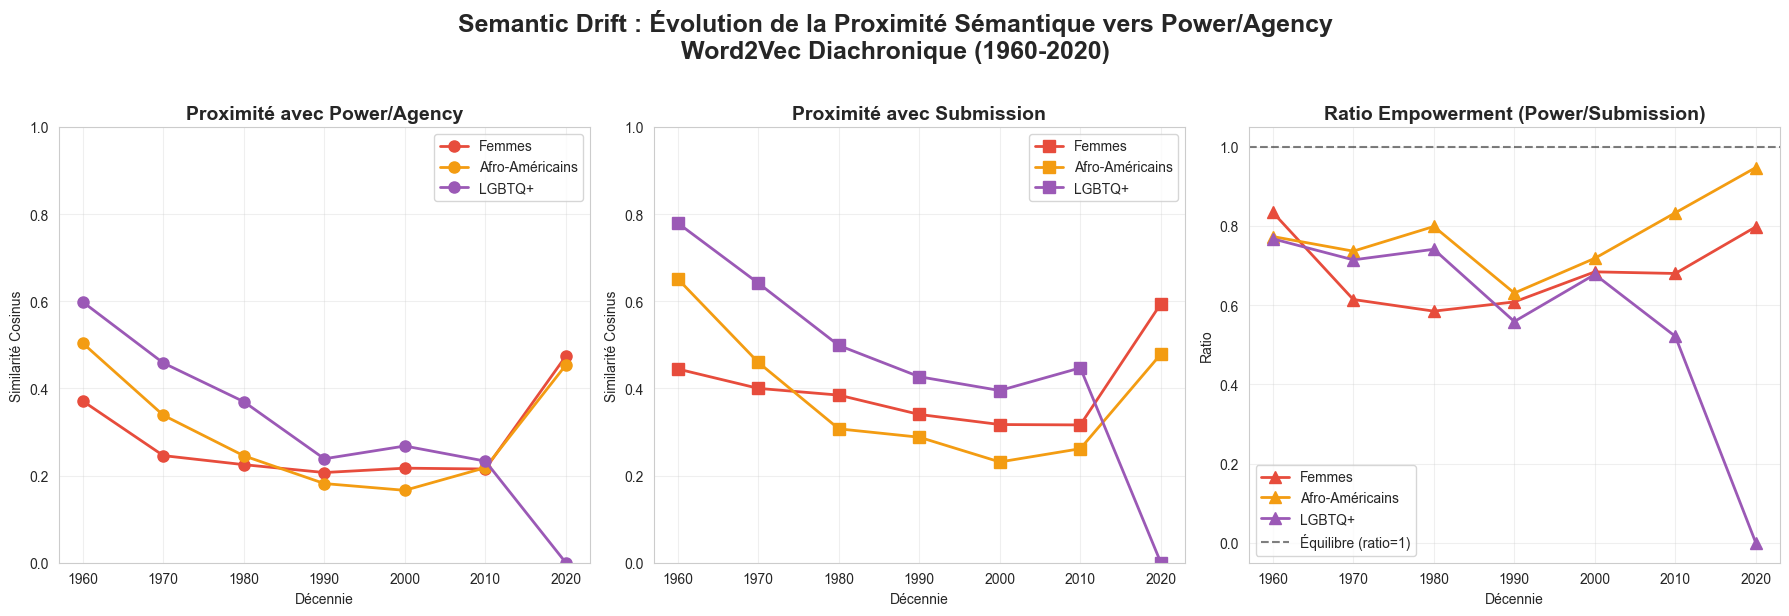

✅ Graphique sauvegardé : results/figures/semantic_drift_power_agency.png

📊 Interprétation :

   Un ratio > 1 signifie que le groupe est PLUS proche de Power/Agency que de Submission.
   Un ratio < 1 signifie que le groupe est PLUS proche de Submission.

   👉 Évolution vers le haut = Empowerment linguistique
   👉 Évolution vers le bas = Renforcement de la soumission


In [10]:
# Créer le graphique d'évolution
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Semantic Drift : Évolution de la Proximité Sémantique vers Power/Agency\n' +
             'Word2Vec Diachronique (1960-2020)',
             fontsize=18, fontweight='bold', y=1.02)

groups = df_proximity['group'].unique()
colors = {'Femmes': '#e74c3c', 'Afro-Américains': '#f39c12', 'LGBTQ+': '#9b59b6'}

# 1. Proximité avec Power/Agency
ax1 = axes[0]
for group in groups:
    group_data = df_proximity[df_proximity['group'] == group]
    ax1.plot(group_data['decade'], group_data['power_similarity'], 
             marker='o', linewidth=2, markersize=8, label=group, color=colors.get(group, 'gray'))

ax1.set_title('Proximité avec Power/Agency', fontsize=14, fontweight='bold')
ax1.set_xlabel('Décennie')
ax1.set_ylabel('Similarité Cosinus')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.set_ylim(0, 1)

# 2. Proximité avec Submission
ax2 = axes[1]
for group in groups:
    group_data = df_proximity[df_proximity['group'] == group]
    ax2.plot(group_data['decade'], group_data['submission_similarity'], 
             marker='s', linewidth=2, markersize=8, label=group, color=colors.get(group, 'gray'))

ax2.set_title('Proximité avec Submission', fontsize=14, fontweight='bold')
ax2.set_xlabel('Décennie')
ax2.set_ylabel('Similarité Cosinus')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.set_ylim(0, 1)

# 3. Ratio Empowerment (Power/Submission)
ax3 = axes[2]
for group in groups:
    group_data = df_proximity[df_proximity['group'] == group]
    ax3.plot(group_data['decade'], group_data['empowerment_ratio'], 
             marker='^', linewidth=2, markersize=8, label=group, color=colors.get(group, 'gray'))

ax3.set_title('Ratio Empowerment (Power/Submission)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Décennie')
ax3.set_ylabel('Ratio')
ax3.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Équilibre (ratio=1)')
ax3.legend()
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/semantic_drift_power_agency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Graphique sauvegardé : results/figures/semantic_drift_power_agency.png")

# Interprétation
print("\n📊 Interprétation :")
print("\n   Un ratio > 1 signifie que le groupe est PLUS proche de Power/Agency que de Submission.")
print("   Un ratio < 1 signifie que le groupe est PLUS proche de Submission.")
print("\n   👉 Évolution vers le haut = Empowerment linguistique")
print("   👉 Évolution vers le bas = Renforcement de la soumission")

## 10. Sauvegarde des Résultats

In [11]:
# Créer le répertoire de résultats
output_dir = Path('../results')
output_dir.mkdir(exist_ok=True)

# Sauvegarder les densités par film
df[['title', 'release_year', 'decade', 'sexism_density', 'racism_density', 
    'homophobia_density', 'total_bias_density']].to_csv(
    output_dir / 'bias_density_by_film.csv', index=False)

print(f"✅ Densités par film : {output_dir / 'bias_density_by_film.csv'}")

# Sauvegarder l'évolution par décennie
df_evolution.to_csv(output_dir / 'bias_evolution_by_decade.csv', index=False)
print(f"✅ Évolution par décennie : {output_dir / 'bias_evolution_by_decade.csv'}")

# Sauvegarder la matrice de co-occurrence
cooccurrence_matrix.to_csv(output_dir / 'cooccurrence_matrix.csv')
print(f"✅ Matrice de co-occurrence : {output_dir / 'cooccurrence_matrix.csv'}")

# Sauvegarder les résultats de proximité sémantique
df_proximity.to_csv(output_dir / 'semantic_proximity_evolution.csv', index=False)
print(f"✅ Proximité sémantique : {output_dir / 'semantic_proximity_evolution.csv'}")

print("\n✅ Tous les résultats sauvegardés !")

✅ Densités par film : ../results/bias_density_by_film.csv
✅ Évolution par décennie : ../results/bias_evolution_by_decade.csv
✅ Matrice de co-occurrence : ../results/cooccurrence_matrix.csv
✅ Proximité sémantique : ../results/semantic_proximity_evolution.csv

✅ Tous les résultats sauvegardés !


## 11. Synthèse et Lien avec les Cours

### 🎓 Concepts Mobilisés (Maria Boritchev - Sémantique)

| **Concept du Cours** | **Application dans le Projet** |
|----------------------|--------------------------------|
| **Niveau Sémantique** | Construction de lexiques de termes problématiques (sens littéral) |
| **Niveau Pragmatique** | Analyse des N-grams pour comprendre le sens en contexte (dénoncer vs renforcer) |
| **N-grams** | Extraction de bigrams autour des groupes sociaux pour identifier les comportements associés |
| **Word Embeddings** | Word2Vec diachronique pour mesurer le déplacement sémantique vers Power/Agency |
| **Co-occurrence** | Matrice Groupes × Comportements pour révéler les rôles attribués |

### 🎯 Réponses aux Questions CSS

#### 1. **Peak Prejudices**
- Décennie la plus violente identifiée par la densité maximale de biais
- Permet de contextualiser historiquement (ex: pré/post Civil Rights Act)

#### 2. **Linguistic Shift**
- Le stacked area chart montre si certains biais diminuent plus vite que d'autres
- Hypothèse : Le racisme explicite diminue, mais le sexisme persiste

#### 3. **Co-occurrence Patterns**
- La heatmap révèle les **rôles sociaux** assignés aux minorités
- Ex: Femmes → Domesticité, Afro-Américains → Crime ?
- **Importance** : Le cinéma structure la pensée du public (Systèmes Socio-techniques)

#### 4. **Semantic Drift**
- Le ratio Power/Submission mesure l'évolution vers l'**empowerment linguistique**
- Si ratio augmente → Les minorités sont de plus en plus associées à l'agency
- Si ratio stagne → Reproduction des schémas de domination

### ⚠️ Limites Méthodologiques

1. **Faux positifs/négatifs** : Certains termes peuvent être utilisés de manière critique
2. **Contexte limité** : Les N-grams ne capturent pas toute la nuance narrative
3. **Biais d'échantillonnage** : Corpus Kaggle non représentatif de TOUT le cinéma
4. **Word2Vec** : Nécessite beaucoup de données, peut être instable sur petites décennies

### 🚀 Extensions Possibles

1. **Analyse de sentiments** : Distinguer usage critique vs renforcement (BERT/GPT)
2. **Analyse par genre de film** : Le racisme est-il plus présent dans les thrillers ?
3. **Analyse par réalisateur** : Identifier les cinéastes progressistes vs conservateurs
4. **Validation humaine** : Annoter un échantillon pour mesurer la précision

---

## 📚 Références Scientifiques

- **Boritchev, M.** (2024). *Niveaux Linguistiques : Sémantique et Pragmatique*. Cours Télécom Paris.
- **Bolukbasi et al.** (2016). "Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings". NeurIPS.
- **Garg et al.** (2018). "Word embeddings quantify 100 years of gender and ethnic stereotypes". PNAS.
- **USC Annenberg** (2020). "Inequality in 1,300 Popular Films".
- **Geena Davis Institute** (2019). "The Reel Truth: Women Aren't Seen or Heard".

---

**Conclusion** : Ce notebook démontre que le cinéma n'est pas un simple miroir de la société, mais un **système socio-technique** qui structure les représentations collectives. L'analyse diachronique révèle les évolutions (ou stagnations) des biais linguistiques, reflétant les luttes sociales (Civil Rights, féminisme, LGBTQ+) tout en participant à la construction de l'espace public.